In [1]:
include("../code/plotting_utilities.jl")
include("../code/ode_helper.jl")
include("../code/learn_polynomial_with_side_info.jl")
using SumOfSquares
using DynamicPolynomials
using MosekTools
using Plots
using Random
using PyPlot
PyPlot.rc("font", family="sans-serif", size=20)
PyPlot.rc("figure", autolayout=true)

Loaded diff equations


In [2]:
function get_vf_for_parameters(params)
    rho, sigma, beta = params
    f(x, y, z) =    [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]
    return f
end

get_vf_for_parameters (generic function with 1 method)

Solving ODE from x0=[1.0, 1.0, 1.0]


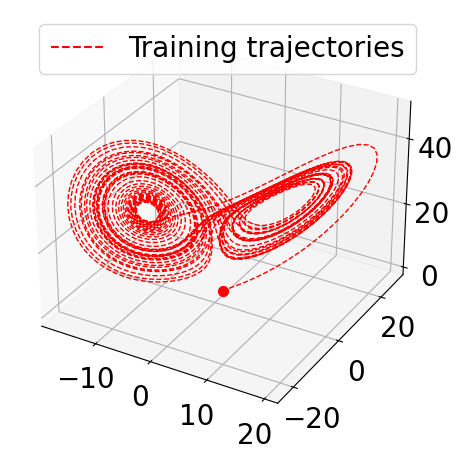

size(sol) = (3, 505)
length = 4000


PyObject <matplotlib.legend.Legend object at 0x7fdfb1f79af0>

In [3]:
gr(size=(600,400))


ode_p = [28., 10., 8. / 3.]

ff = get_vf_for_parameters(ode_p)

x0 =  [1.0, 1.0, 1.0]
sol = solve_ode_3d(ff, x0, tspan=(0., 40.), length=4000)
PyPlot.plot3D(sol..., color=:red, ls="--", lw=1)
PyPlot.scatter3D(x0[1], x0[2], x0[3], color=:red, s=50)
PyPlot.plot([], [], [], color=:red, ls="--", label="Training trajectories")
PyPlot.legend()

In [4]:
function get_training_data(x0; noise_level=1e-6, verbose=true, length=10, T=1.)
    Random.seed!(0)
    training_x = hcat(solve_ode_3d(ff, x0; verbose=verbose, tspan=(0, T), length=length)...)'
    training_xdot = ff.(training_x[1, :], training_x[2, :], training_x[3, :])
    training_xdot = hcat(training_xdot...)
    training_xdot = training_xdot + noise_level * randn(size(training_xdot))
    return training_x, training_xdot
end


∞ = 1e9
function test_error(vf, initial_conditions; verbose=false)
    penalty = u -> sqrt(sum(u.^2))
    error = 0
    for x0 in initial_conditions
        sol = []
        try
            sol = solve_ode_3d(vf, x0, verbose=verbose)
        catch y
            return ∞
        end
        true_sol =  solve_ode_3d(ff, x0, verbose=verbose)
        for  i=1:size(sol, 1)
            error += penalty(sol[i] .- true_sol[i])
        end
        if verbose
            println("at $x0, error = $error")
        end
    end
    return error / size(initial_conditions, 1)
end

# should ne 0
test_error(ff, [x0])


0.0

In [49]:
pos_x(model, p, x) = begin
    Set = @set x[2] - x[1] >=  0
    @constraint(model, p[1] >= 0, domain=Set) 
end


equilibrium_points(model, p, x) = begin
    for pi in p
        @constraint model pi(0, 0, 0) == 0
    end
end

equilibrium_points (generic function with 1 method)

In [63]:
T = 10.
N = 10
verbose = true
deg = 3
noise_level=1e-2
initial_conditions = [[1.0, 1.0, 1.0],  
    [.1, .2, .3], 
    [-.4, .2, -.3],
    [-1, 0., .5]
]

training_x = []
training_xdot = []
for (i, x0)=enumerate(initial_conditions)
    x, xdot = get_training_data(x0, 
        noise_level=noise_level, 
        verbose=verbose, length=N, T=T)
    if i > 1
    training_x = hcat(training_x, x)
    training_xdot = hcat(training_xdot, xdot)
    else
        training_x = x
        training_xdot = xdot
    end
    
end

side_info = Dict(
    "equilibrium_points" => equilibrium_points,
    "pos_x" => pos_x,

 )

p_opt, opt_value = 
fit_polynomial_to_data_with_side_info(training_x, training_xdot; 
    side_info=side_info, verbose=verbose, deg=deg, regularization=0.)
@show round.(p_opt, digits=2)
@show round.(opt_value, digits=6)

p_opt_as_f = (a, b, c) ->  map(pi -> pi([a,b, c]), p_opt)
l2_error = sum( (hcat(p_opt_as_f.(training_x[1, :], training_x[2, :], training_x[3, :])...) .- training_xdot).^2) / N
diff_f = p_opt - ff(variables(p_opt)...) 
coeff_error = norm(hcat(coefficients.(diff_f)...))
println("p - f = ", round.(diff_f, digits=2))
println("coeff(p - f) = ", coeff_error)
println("l2^2 error: ", l2_error)

Solving ODE from x0=[1.0, 1.0, 1.0]
size(sol) = (3, 102)
length = 10
Solving ODE from x0=[0.1, 0.2, 0.3]
size(sol) = (3, 97)
length = 10
Solving ODE from x0=[-0.4, 0.2, -0.3]
size(sol) = (3, 97)
length = 10
Solving ODE from x0=[-1.0, 0.0, 0.5]
size(sol) = (3, 105)
length = 10
n = 3
size(training_xdot) = (3, 40)
size(training_x) = (3, 40)
deg = 3
solver = MathOptInterface.OptimizerWithAttributes(Mosek.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[MathOptInterface.RawParameter("QUIET") => true])
Define polynomial variable
Define p(training)
side_info = Dict{String, Function}("equilibrium_points" => equilibrium_points, "pos_x" => pos_x)
Imposing equilibrium_points
Imposing pos_x
Define objective
Solving
value(objective) = 0.07442298828816767
round.(p_opt, digits = 2) = Polynomial{true, Float64}[-10.01x₁ + 10.01x₂, -0.01x₁² + 0.01x₁x₂ - 0.99x₁x₃ + 27.98x₁ - 0.98x₂ + 0.01x₃, -0.02x₁² + 1.03x₁x₂ + 0.01x₁x₃ - 0.01x₂² - 0.02x₁ - 0.01x₂ - 2.65x₃]
round.(opt_value, digits = 6

LoadError: DimensionMismatch("vectors must have same lengths")

Solving ODE from x0=[1.0, 1.0, 1.0]
size(sol) = (3, 20)
length = 100


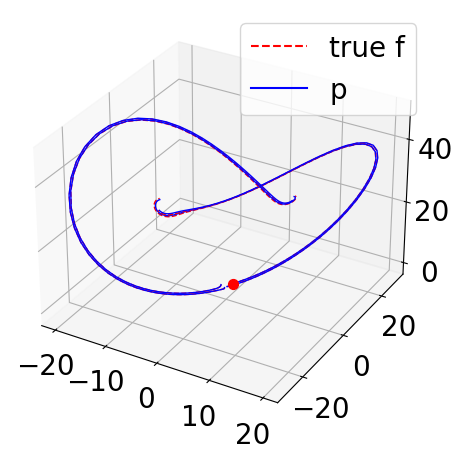

Solving ODE from x0=[1.0, 1.0, 1.0]
size(sol) = (3, 20)
length = 100
Solving ODE from x0=[0.1, 0.2, 0.3]
size(sol) = (3, 20)
length = 100
Solving ODE from x0=[0.1, 0.2, 0.3]
size(sol) = (3, 20)
length = 100
Solving ODE from x0=[-0.4, 0.2, -0.3]
size(sol) = (3, 22)
length = 100
Solving ODE from x0=[-0.4, 0.2, -0.3]
size(sol) = (3, 22)
length = 100
Solving ODE from x0=[-1.0, 0.0, 0.5]
size(sol) = (3, 27)
length = 100
Solving ODE from x0=[-1.0, 0.0, 0.5]
size(sol) = (3, 27)
length = 100


PyObject <matplotlib.legend.Legend object at 0x7fdf911b19d0>

In [66]:
T = 1.
for x0 in [initial_conditions...,] 
    true_sol = solve_ode_3d(ff, x0, tspan=(0., T), length=100)
    PyPlot.plot3D(true_sol..., color=:red, ls="--", lw=1)

    approx_sol = solve_ode_3d(p_opt_as_f, x0, tspan=(0., T), length=100)
    PyPlot.plot3D(approx_sol..., color=:blue, ls="-", lw=1)
end

PyPlot.scatter3D(x0[1], x0[2], x0[3], color=:red, s=50)
PyPlot.plot([], [], [], color=:red, ls="--", label="true f")
PyPlot.plot([], [], [], color=:blue, ls="-", label="p")

PyPlot.legend()

In [8]:
#ff.(hcat(true_sol...)'...)
xi = hcat(true_sol...)[100, :]
ff(xi...) - p_opt_as_f(xi...)

LoadError: UndefVarError: true_sol not defined

In [9]:
round.(ff(variables(p_opt)...) - p_opt, digits=2)

3-element Vector{Polynomial{true, Float64}}:
 0.97x₁⁵ + 0.89x₁⁴x₂ + 0.29x₁⁴x₃ - 3.36x₁³x₂² + 0.21x₁³x₂x₃ - 0.34x₁³x₃² + 1.78x₁²x₂³ - 0.8x₁²x₂²x₃ - 0.02x₁²x₂x₃² - 0.12x₁²x₃³ + 0.05x₁x₂⁴ + 0.38x₁x₂³x₃ + 0.32x₁x₂²x₃² + 0.03x₁x₂x₃³ + 0.01x₁x₃⁴ - 0.14x₂⁵ - 0.03x₂⁴x₃ - 0.11x₂³x₃² + 0.05x₂²x₃³ + 0.01x₂x₃⁴ + 0.01x₃⁵ - 3.16x₁⁴ + 1.43x₁³x₂ + 8.44x₁³x₃ + 1.94x₁²x₂² - 3.34x₁²x₂x₃ + 2.35x₁²x₃² + 1.02x₁x₂³ - 3.84x₁x₂²x₃ - 0.55x₁x₂x₃² - 0.07x₁x₃³ - 1.02x₂⁴ + 2.14x₂³x₃ - 1.13x₂²x₃² - 0.59x₂x₃³ - 0.48x₃⁴ - 2.51x₁³ - 5.0x₁²x₂ + 3.96x₁²x₃ - 4.28x₁x₂² + 0.67x₁x₂x₃ - 1.59x₁x₃² - 4.76x₂³ + 1.11x₂²x₃ + 7.46x₂x₃² + 5.21x₃³ - 1.42x₁² + 2.83x₁x₂ - 2.47x₁x₃ - 0.73x₂² + 2.94x₂x₃ - 2.71x₃² - 2.9x₁ + 0.76x₂ + 0.18x₃
 0.58x₁⁵ - 8.28x₁⁴x₂ + 0.38x₁⁴x₃ + 15.84x₁³x₂² + 2.0x₁³x₂x₃ + 0.38x₁³x₃² - 7.85x₁²x₂³ - 4.75x₁²x₂²x₃ + 0.01x₁²x₂x₃² - 0.34x₁²x₃³ - 2.31x₁x₂⁴ + 4.17x₁x₂³x₃ - 1.31x₁x₂²x₃² + 0.02x₁x₂x₃³ + 1.87x₂⁵ - 1.43x₂⁴x₃ + 0.94x₂³x₃² + 0.1x₂²x₃³ + 0.03x₂x₃⁴ + 0.03x₃⁵ + 9.89x₁⁴ - 9.91x₁³x₂ - 12.58x₁³x₃ - 13.0x₁²x₂² + 2

In [10]:
sum( (hcat(ff.(training_x[1, :], training_x[2, :], training_x[3, :])...) .- training_xdot).^2)


0.0